<a href="https://colab.research.google.com/github/Nidhi-Sinha01/CodeClauseInternship_ArtificialIntelligenceProject/blob/main/Task_3_Blindness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Name - Blindness Detection**
## **Developed By - Ajay Thakur (2016kuec2026@iiitkota.ac.in)**
## **Branch Name - Electronics and Communication Engineering**
## **Institute Name - Indian Institute of Information Technology Kota (An Institute of National Importance under an Act of Parliament)**
## **Submitted To - CodeClause Pvt. Ltd.**
## **Project Link (GitHub) - [Click here](https://github.com/ajaythakur3369/CodeClauseInternship_ProjectName)**
## **Project Link (Drive) - [Click here](https://colab.research.google.com/drive/1237etYEzrjNBHFXHuvtZ0UX9ZcxIGKc_)**




## **Importing necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
from random import randrange

import os
#print(os.listdir("../input"))

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded
)

## **Introduction**

##### Diabetic retinopathy is the leading cause of blindness among working aged adults. Millions of people suffer from this decease. People with diabetes can have an eye disease called diabetic retinopathy. This is when high blood sugar levels cause damage to blood vessels in the retina. These blood vessels can swell and leak. Or they can close, stopping blood from passing through. Sometimes abnormal new blood vessels grow on the retina. All of these changes can lead to blindness.

## **Stages of Diabetic Eye Disease**

##### **NPDR (non-proliferative diabetic retinopathy):** With NPDR, tiny blood vessels leak, making the retina swell. When the macula swells, it is called macular edema. This is the most common reason why people with diabetes lose their vision. Also with NPDR, blood vessels in the retina can close off. This is called macular ischemia. When that happens, blood cannot reach the macula. Sometimes tiny particles called exudates can form in the retina. These can affect vision too.



##### **PDR (proliferative diabetic retinopathy):** PDR is the more advanced stage of diabetic eye disease. It happens when the retina starts growing new blood vessels. This is called neovascularization. These fragile new vessels often bleed into the vitreous. If they only bleed a little, you might see a few dark floaters. If they bleed a lot, it might block all vision. These new blood vessels can form scar tissue. Scar tissue can cause problems with the macula or lead to a detached retina. PDR is very serious, and can steal both your central and peripheral (side) vision.

## **Load Data**

Load training and testing csv files containing image filenames and corresponding labels (only for training set):

In [ ]:
# Access the Drive from Colab, for accessing the file
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# load csv files with labels as pandas dataframes
train = pd.read_csv('/content/drive/MyDrive/Folders/blindness_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Folders/blindness_test.csv')

In [ ]:
# find out the number of images in test and train sets
print('Number of images in training set is {}'.format(len(train)))
print('Number of images in test set is {}'.format(len(test)))

Number of images in training set is 3662
Number of images in test set is 1928


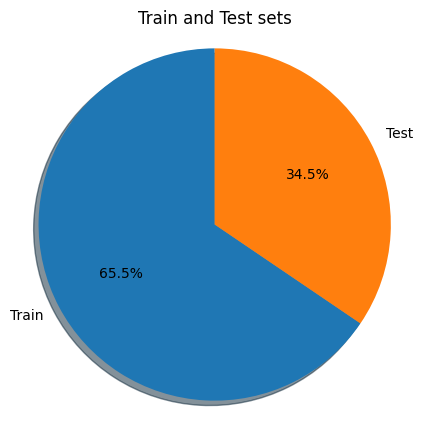

In [ ]:
# Plot pie chart
labels = 'Train', 'Test'
sizes = len(train), len(test)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Train and Test sets')
plt.show()

Both training and testing datasets are not too large.

Training dataset is about 3 times greater than the testing dataset.

## **Analyze Train Set Labels**

Plot pie chart with percentage of images of each diabetic retinopathy severity condition:

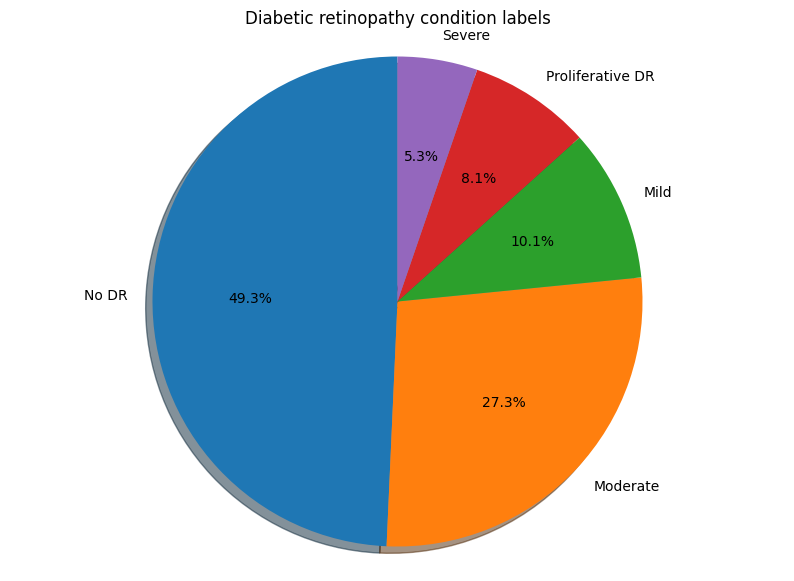

In [ ]:
# Plot pie chart
labels = 'No DR', 'Moderate', 'Mild', 'Proliferative DR', 'Severe'
sizes = train.diagnosis.value_counts()

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Diabetic retinopathy condition labels')
plt.show()

We can see that the training dataset is **very imbalanced**. There are ten times more images with no DR than images with the severe DR condition.

**Data augmentation** is required to perform the classification.

## **Visualize Sample Images**

Let's plot fundus photography images from the training set of different conditions:

In [ ]:
# define paths to train and test images
TRAIN_IMG_PATH = "/content/drive/MyDrive/Folders/blindness_train_images/"  # /content/drive/MyDrive/folders/blindness_train.csv
TEST_IMG_PATH = "/content/drive/MyDrive/Folders/blindness_test_images/"

# function to plot a grid of images
def view_fundus_images(images, title = ''):
    """
    Function to plot grid with several examples of fundus images.
    INPUT:
        train - array with filenames for images and condition labels

    OUTPUT: None
    """
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))

    for im in range(0, height * width):
        # open image
        image = Image.open(os.path.join(TRAIN_IMG_PATH,images[im] + '.png'))
        i = im // width
        j = im % width
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')

    # set suptitle
    plt.suptitle(title)
    plt.show()

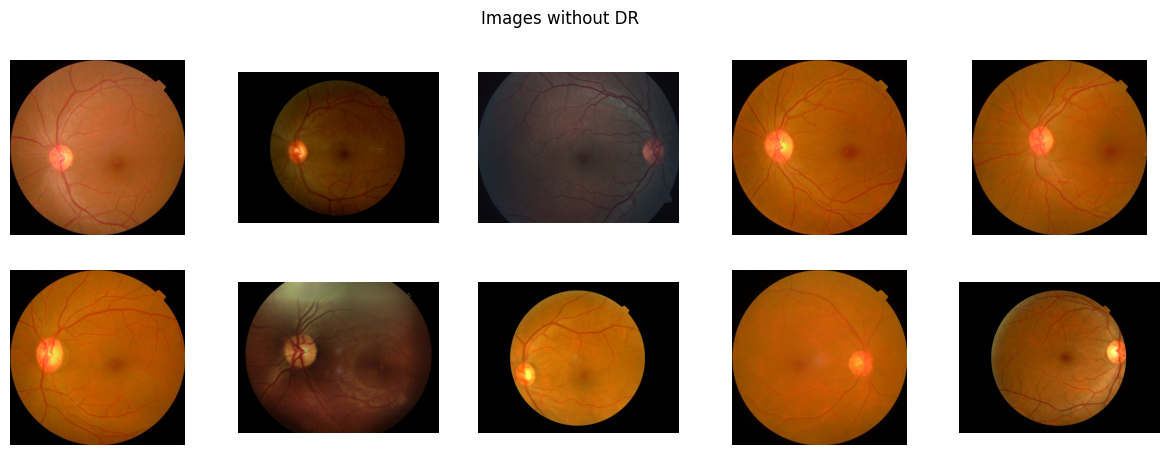

In [ ]:
view_fundus_images(train[train['diagnosis'] == 0][:10].id_code.values, title = 'Images without DR')

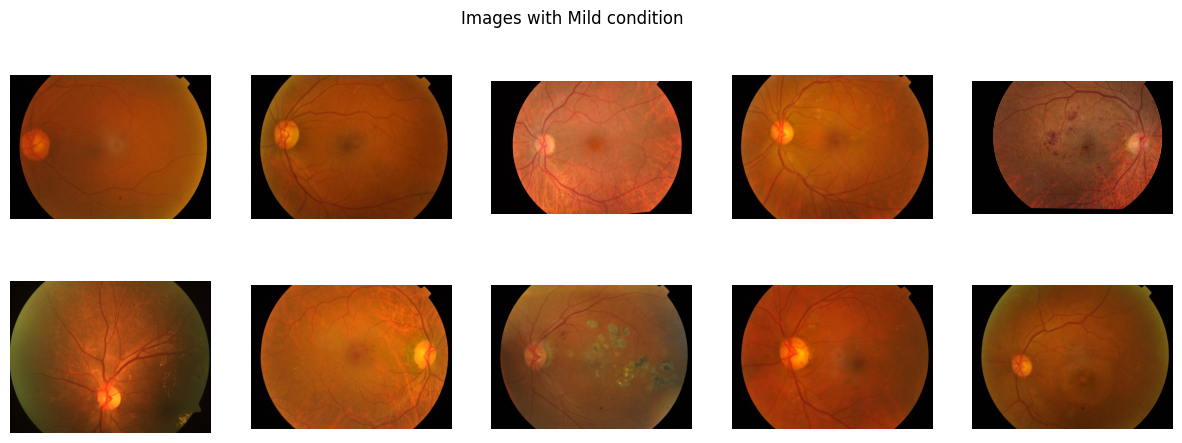

In [ ]:
view_fundus_images(train[train['diagnosis'] == 1][:10].id_code.values, title = 'Images with Mild condition')

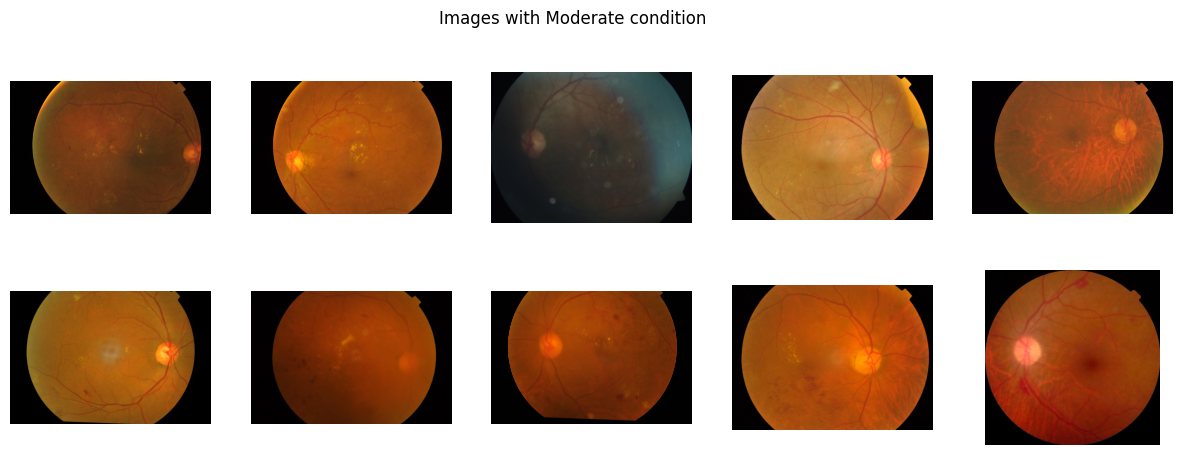

In [ ]:
view_fundus_images(train[train['diagnosis'] == 2][:10].id_code.values, title = 'Images with Moderate condition')

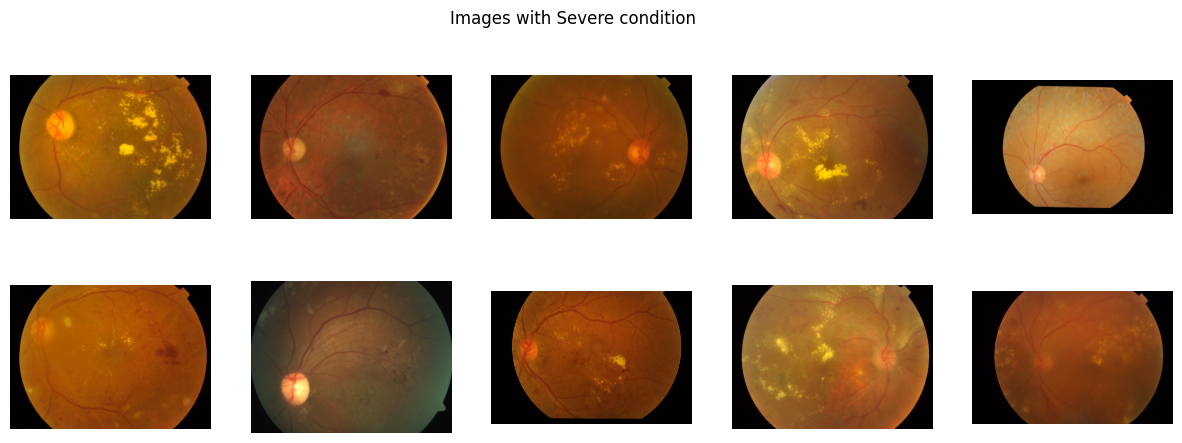

In [ ]:
view_fundus_images(train[train['diagnosis'] == 3][:10].id_code.values, title = 'Images with Severe condition')

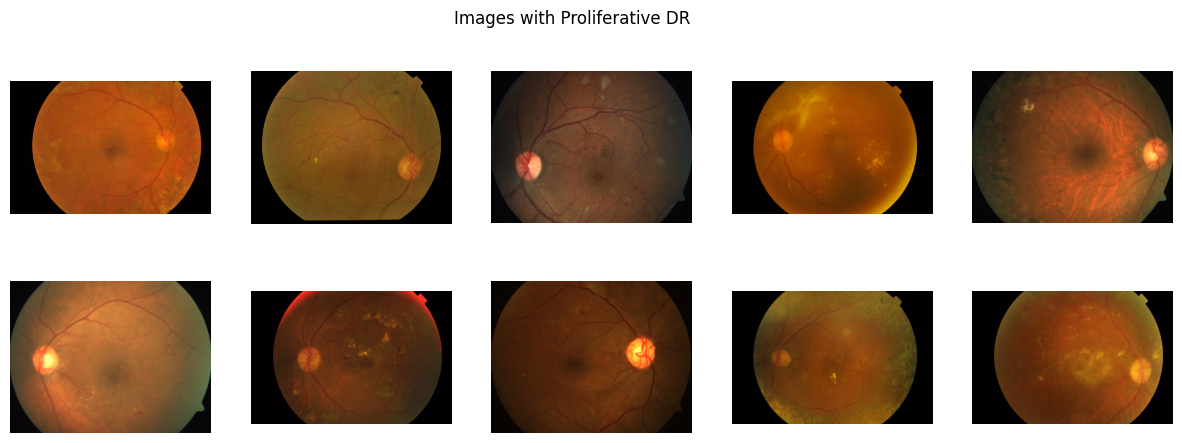

In [ ]:
view_fundus_images(train[train['diagnosis'] == 4][:10].id_code.values, title = 'Images with Proliferative DR')

Just glancing through various images we can say:

* Images are of different sizes. Height and width ratio varies. That is why **image cropping or padding is required**.
* Pictures are taken with various scales. **Random cropping** augmentation is required.
* Lighting and colors vary greately. Augmentations which **adjust brightness and color scales** are required.

## **Analyze Image Sizes**

Plot histograms for image sizes (used code from this kernel for the analysis):

In [ ]:
def get_image_sizes(df, train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        df - dataframe containing image filenames
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_IMG_PATH
    else:
        path = TEST_IMG_PATH

    widths = []
    heights = []

    images = df.id_code

    max_im = Image.open(os.path.join(path, images[0] + '.png'))
    min_im = Image.open(os.path.join(path, images[0] + '.png'))

    for im in range(0, len(images)):
        image = Image.open(os.path.join(path, images[im] + '.png'))
        width, height = image.size

        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)

    return widths, heights, max_im, min_im

In [ ]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train, train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(test, train = False)

In [ ]:
print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 4288
Minimum width for training set is 474
Maximum height for training set is 2848
Minimum height for training set is 358


In [ ]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 2896
Minimum width for test set is 640
Maximum height for test set is 1958
Minimum height for test set is 480


<ipython-input-19-902dcd8425ef>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_widths, kde=False, label='Train Width')
<ipython-input-19-902dcd8425ef>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_heights, kde=False, label='Train Height')


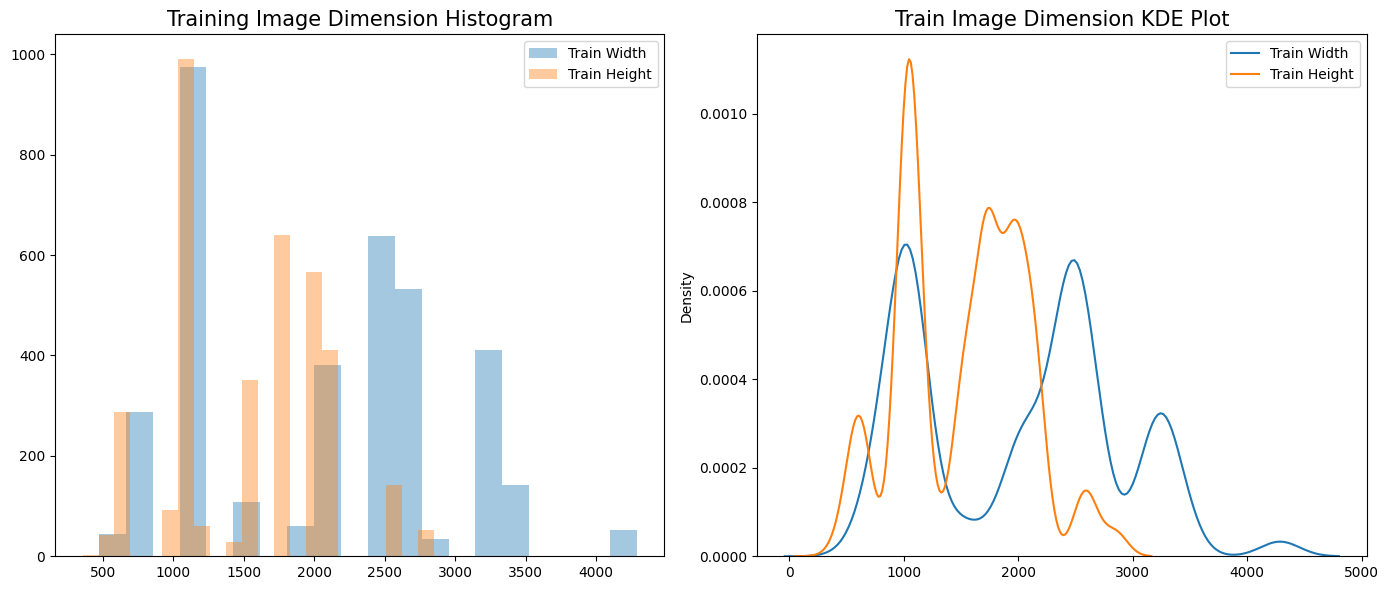

In [ ]:
# Plot Histograms and KDE plots for images from the training set
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(train_widths, kde=False, label='Train Width')
sns.distplot(train_heights, kde=False, label='Train Height')
plt.legend()
plt.title('Training Image Dimension Histogram', fontsize=15)

plt.subplot(122)
sns.kdeplot(train_widths, label='Train Width')
sns.kdeplot(train_heights, label='Train Height')
plt.legend()
plt.title('Train Image Dimension KDE Plot', fontsize=15)

plt.tight_layout()
plt.show()

<ipython-input-20-9475f05fd41a>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_widths, kde=False, label='Test Width')
<ipython-input-20-9475f05fd41a>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_heights, kde=False, label='Test Height')


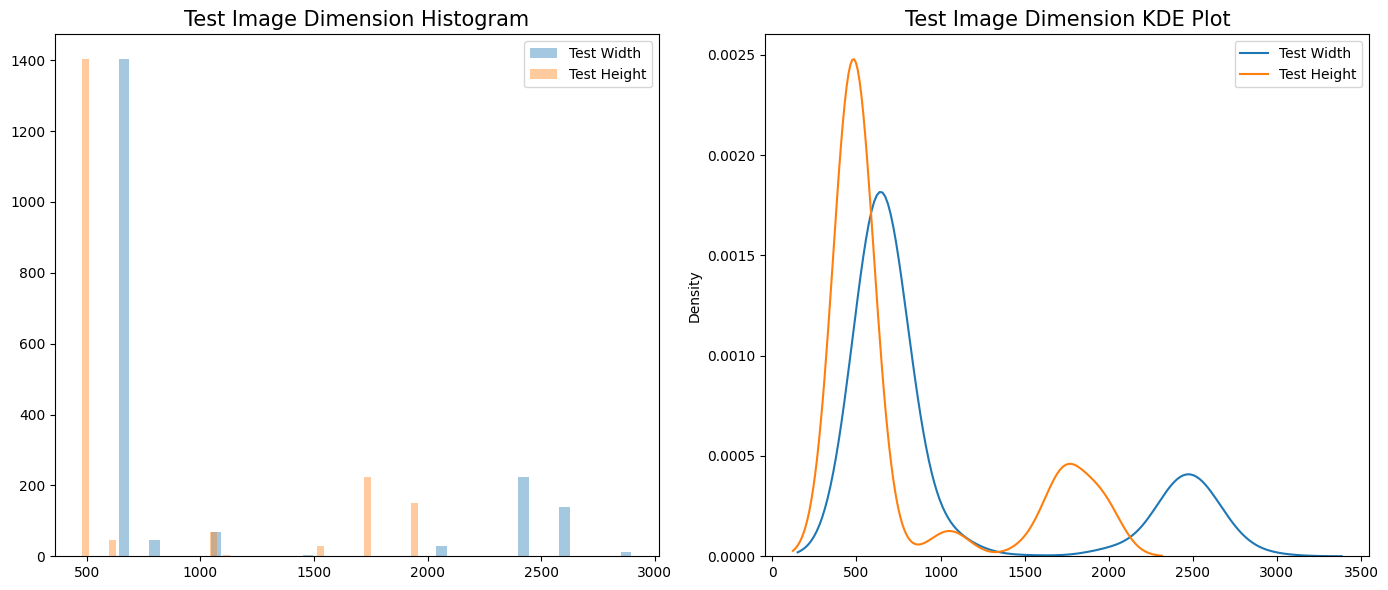

In [ ]:
# Plot Histograms and KDE plots for images from the test set
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(test_widths, kde=False, label='Test Width')
sns.distplot(test_heights, kde=False, label='Test Height')
plt.legend()
plt.title('Test Image Dimension Histogram', fontsize=15)

plt.subplot(122)
sns.kdeplot(test_widths, label='Test Width')
sns.kdeplot(test_heights, label='Test Height')
plt.legend()
plt.title('Test Image Dimension KDE Plot', fontsize=15)

plt.tight_layout()
plt.show()

We see that we have very different distributions of image sizes for train and test datasets.

## **Plot largest and smallest images**

Let's look and the largest and the smallest images from both sets.

Image with the largest width from training set:

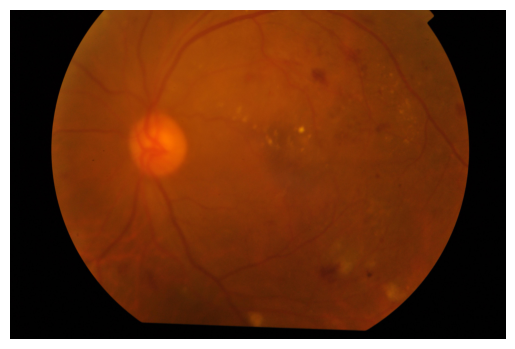

In [ ]:
plt.axis('off')
plt.imshow(max_train) #plot the data

Image with the smallest width from training set:

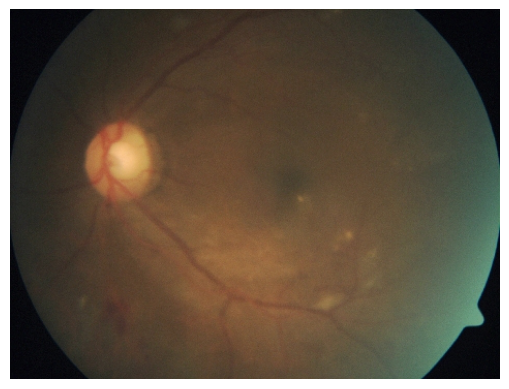

In [ ]:
plt.axis('off')
plt.imshow(min_train) #plot the data

Image with the largest width from test set:

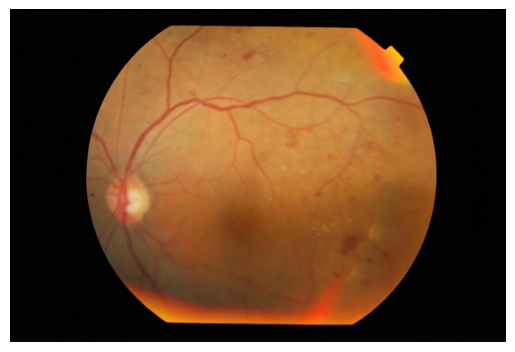

In [ ]:
plt.axis('off')
plt.imshow(max_test) #plot the data

Image with the smallest width from training set:

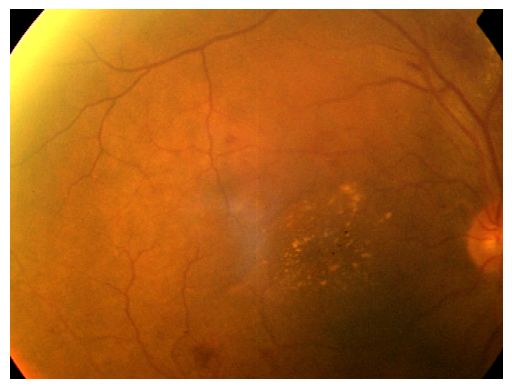

In [ ]:
plt.axis('off')
plt.imshow(min_test) #plot the data

## **Playing with Augmentations**

Finally, I would like to play with some augmentations.

This will help to have an impression of augmented dataset.

In [ ]:
# define the dictionary for labels
diagnosis_dict = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

In [ ]:
# function to plot a grid of images
def view_fundus_images_labels(train, rand_indices, aug = None, title = ''):
    """
    Function to plot grid with several examples of fundus images.
    INPUT:
        train - array with filenames for images and condition labels
        rand_indices - indices of images to plot
        title - plot title

    OUTPUT: None
    """
    width = 5
    height = 2
    counter = 0
    fig, axs = plt.subplots(height, width, figsize=(15,5))

    for im in rand_indices:
        # open image
        image = Image.open(os.path.join(TRAIN_IMG_PATH, train.iloc[im].id_code + '.png'))

        if aug is not None:
            image = aug(image=np.array(image))['image']

        i = counter // width
        j = counter % width
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')

        diagnosis = train[train['id_code'] == train.iloc[im].id_code].diagnosis.values[0]

        axs[i,j].set_title(diagnosis_dict[diagnosis])
        counter += 1

    # set suptitle
    plt.suptitle(title)
    plt.show()

Plot random images from the training set:

In [ ]:
# get some random image indices from the training set
rand_indices = [randrange(len(train)) for x in range(0,10)]
rand_indices

[3017, 1936, 1607, 2328, 479, 1470, 3561, 1156, 2670, 971]

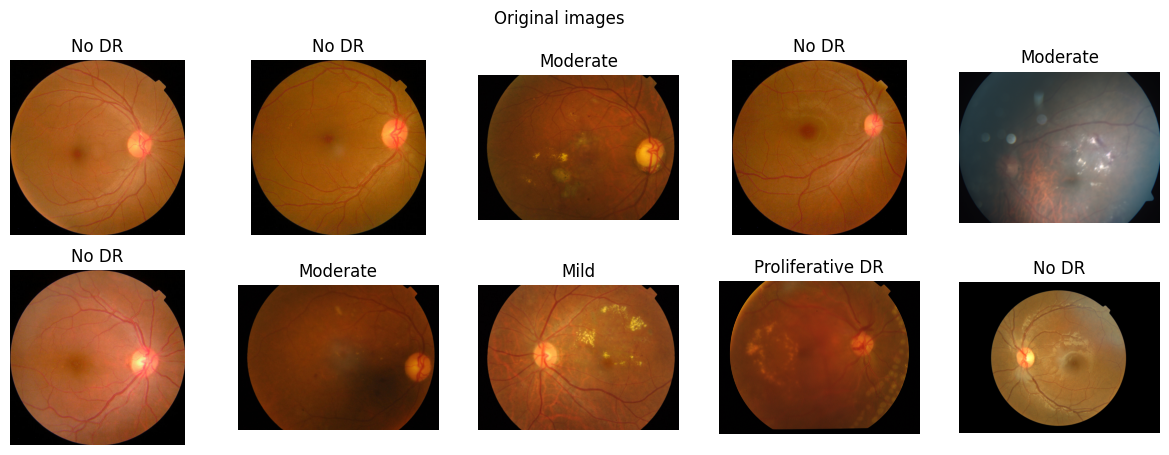

In [ ]:
# plot original images
view_fundus_images_labels(train, rand_indices, title = 'Original images')

Now let's play with some albumentation filters:

Augment the images with CLAHE:

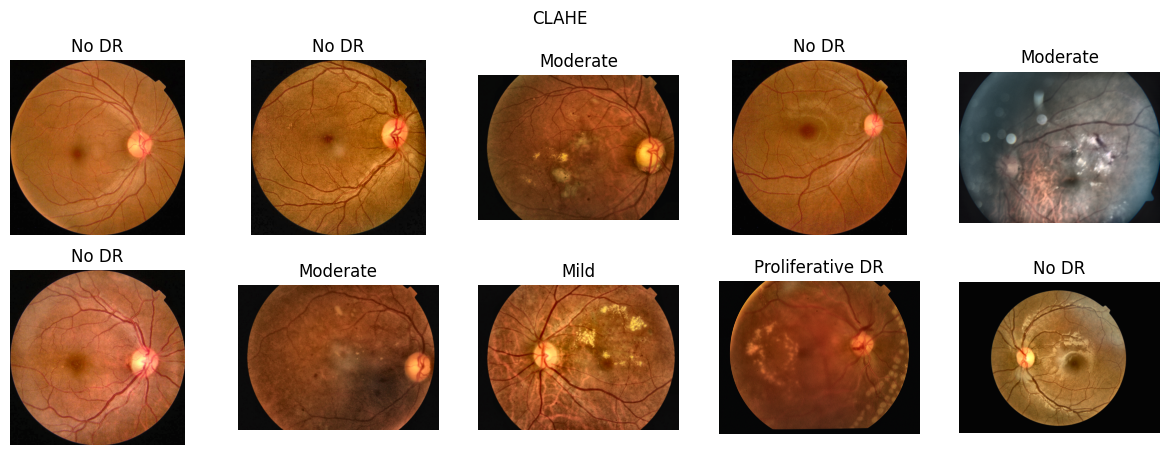

In [ ]:
aug = CLAHE(p=1)
view_fundus_images_labels(train, rand_indices, aug, title = 'CLAHE')

Try adding some gaussian noise:

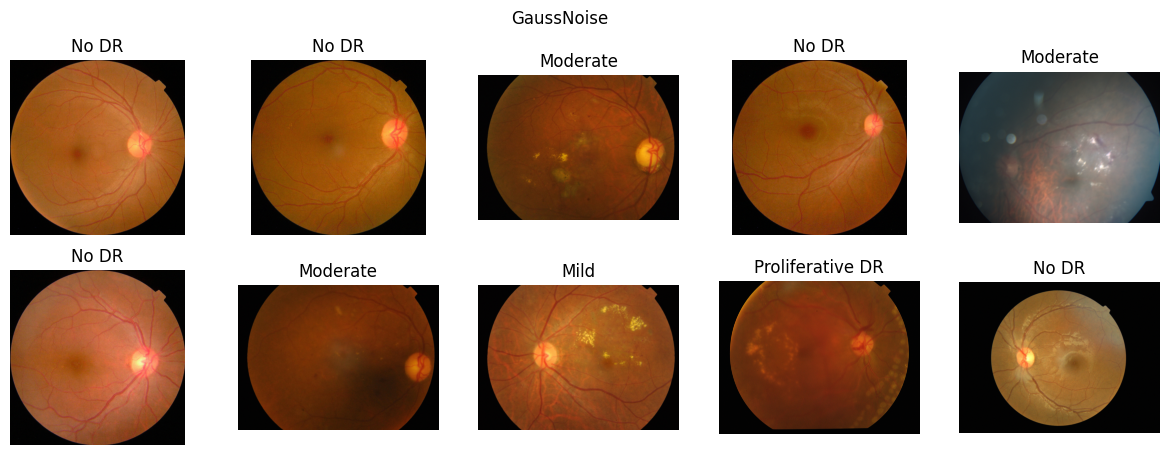

In [ ]:
aug = GaussNoise(p=1)
view_fundus_images_labels(train, rand_indices, aug, title = 'GaussNoise')

Playing with brightness and constrast:

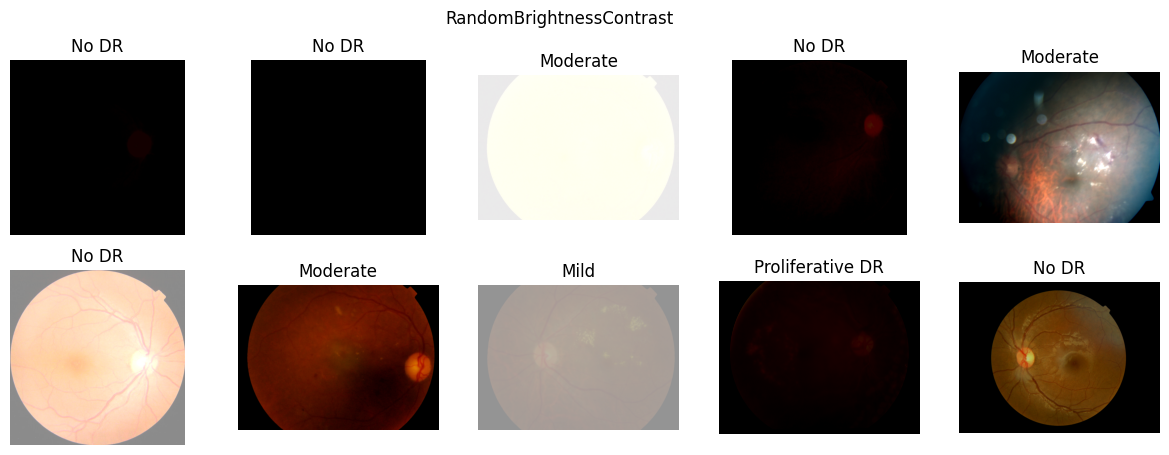

In [ ]:
aug = RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p = 1)
view_fundus_images_labels(train, rand_indices, aug, title = 'RandomBrightnessContrast')

See how random brightness and contrast affect images. This filter should certainly be used for data augmentation.

Padding images:

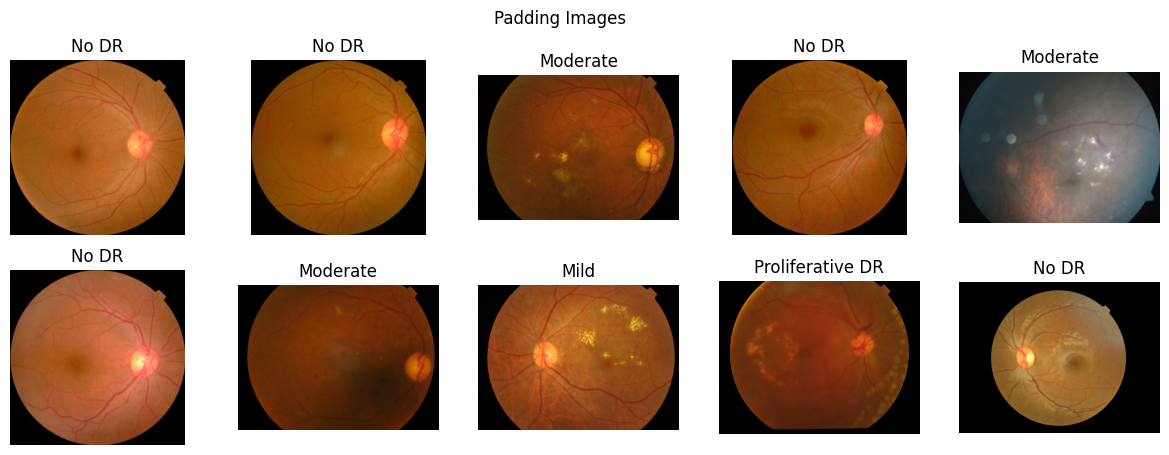

In [ ]:
aug = PadIfNeeded(min_height=1024, min_width=1024, p = 1)
view_fundus_images_labels(train, rand_indices, aug, title = 'Padding Images')

## **Conclusion**

After the EDA we can say the following:

* The dataset **is heavily imbalanced. Data augmentation is required**.
* The **distribution of sizes of images from train and test sets is different**. This will probably have an impact on classification results.

In this EDA we also explored augmented images to have an impression what augmented dataset will look like.